# FDA Citations Topic Modeling

Source: https://www.fda.gov/inspections-compliance-enforcement-and-criminal-investigations/inspection-references/inspection-citation

The dataset pulled from fda.gov details citations made during FDA inspections conducted of clinical trials, Institutional Review Boards (IRBs), and facilities that manufacture, process, pack, or hold an FDA-regulated product that is currently marketed. Specifically, the information comes from the electronic inspection tool of FDA Form 483.  

__Note:__ The citations in this database are only from inspections in the _Inspection Classification Database_, which does not represent a comprehensiv listing of all conducted inspections. For example, some inspection data may not be posted until a final enforcement action is taken.

In [37]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the code."></form>
''')

## Import Packages

In [2]:
import nltk

import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Prepare Stopwords

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['deficient', 'used', 'purporting', 'meet'])

## Import Citations

In [4]:
# read dataframe into python
df = pd.read_excel("Inspection_Citation_(10-1-2008_through_7-22-2020)_0.xlsx")

In [5]:
df = df.rename(columns={'Long Description': 'long_description'})

drugs = df[(df['Program Area'] == "Drugs") &
           (df['Country/Area'] == "United States")].reset_index().drop('index', axis = 1)

drugs.head()

,Firm Name,City,State,Country/Area,Inspection End Date,Program Area,CFR/Act Number,Short Description,long_description
0,AmerisourceBergen Drug Corporation,Des Moines,WA,United States,2008-10-07,Drugs,21 CFR 211.68(a),Calibration/Inspection/Checking not done,Routine calibration of mechanical equipment is...
1,AmerisourceBergen Drug Corporation,Des Moines,WA,United States,2008-10-07,Drugs,21 CFR 211.142(b),Storage under appropriate conditions,Drug products are not stored under appropriate...
2,AmerisourceBergen Drug Corporation,Des Moines,WA,United States,2008-10-07,Drugs,21 CFR 211.204,Returned drug products with doubt cast as to s...,"Returned drug products held, stored or shipped..."
3,"IPR Pharmaceuticals, Inc.",Canovanas,PR,United States,2008-10-08,Drugs,21 CFR 211.160(b)(2),"In-process samples representative, identified ...",Samples taken of in-process materials for dete...
4,"IPR Pharmaceuticals, Inc.",Canovanas,PR,United States,2008-10-08,Drugs,21 CFR 211.160(b)(4),Establishment of calibration procedures,Procedures describing the calibration of instr...


## Pre-process texts

In [6]:
# convert to list
data = drugs.long_description.values.tolist()

# remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Routine calibration of mechanical equipment is not performed according to a '
 'written program designed to assure proper performance.']


## Tokenize words and Clean-up text

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc = True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))
        
data_words = list(sent_to_words(data))

data_words[:1]

[['routine',
  'calibration',
  'of',
  'mechanical',
  'equipment',
  'is',
  'not',
  'performed',
  'according',
  'to',
  'written',
  'program',
  'designed',
  'to',
  'assure',
  'proper',
  'performance']]

## Creating Bigram and Trigram Models

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count = 5, threshold = 100) # higher threshold fewer phrases
trigram = gensim.models.Phrases(data_words, min_count = 5, threshold = 100)

# Faster way to get a sentence clubbed as a trigram/brigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

trigram_mod[bigram_mod[data_words[0]]]

['routine',
 'calibration',
 'of',
 'mechanical',
 'equipment',
 'is',
 'not',
 'performed',
 'according',
 'to',
 'written',
 'program',
 'designed',
 'to',
 'assure',
 'proper',
 'performance']

## Remove Stopwords, Make Bigrams

In [9]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 

# define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts): #, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        #doc = join(sent) # nlp(" ".join(sent))
        texts_out.append([lemmatizer.lemmatize(token) for token in sent]) # if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# remove stop words
data_words_nostops = remove_stopwords(data_words)

# form bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])

# do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams)

## Create Dictionary and Corpus Needed for Topic Modeling

In [11]:
# Create dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Ceate corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# human readable version of corpus
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]
[[('according', 1), ('assure', 1), ('calibration', 1), ('designed', 1), ('equipment', 1), ('mechanical', 1), ('performance', 1), ('performed', 1), ('program', 1), ('proper', 1), ('routine', 1), ('written', 1)]]


## Determining Number of Topics

In [12]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus = corpus, num_topics = num_topics, id2word = id2word,
                                               random_state = 4,
                                               passes = 25)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [13]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=60, step=6)

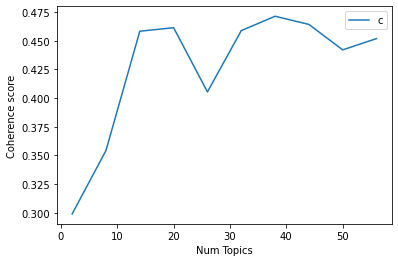

In [14]:
# Show graph
limit=60; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Based on the above graph, it appears that the ideal number of topics is __20__. A slightly higher coherence score can be achieved by increasing num_topics up to 40, but then the topics get far too granular and nuanced.

## Building the Topic Model

In [15]:
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = id2word,
                                           num_topics = 20,
                                           random_state = 4,
                                           passes = 25)

## View the topics in LDA Model

In [16]:
# Print the Keywords in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.127*"process" + 0.090*"control" + 0.065*"procedure" + 0.056*"established" '
  '+ 0.053*"production" + 0.041*"material" + 0.041*"performance" + '
  '0.035*"drug" + 0.035*"product" + 0.034*"followed"'),
 (1,
  '0.105*"aseptic" + 0.099*"area" + 0.076*"regarding" + 0.072*"processing" + '
  '0.060*"condition" + 0.060*"system" + 0.048*"requirement" + 0.028*"assure" + '
  '0.027*"environmental" + 0.026*"conducted"'),
 (2,
  '0.074*"instrument" + 0.071*"calibration" + 0.071*"established" + '
  '0.053*"rejected" + 0.047*"written" + 0.045*"done" + 0.044*"suitable" + '
  '0.043*"apparatus" + 0.042*"device" + 0.039*"recording"'),
 (3,
  '0.084*"written" + 0.071*"record" + 0.054*"performed" + 0.052*"equipment" + '
  '0.047*"investigation" + 0.044*"assure" + 0.042*"designed" + 0.042*"program" '
  '+ 0.042*"proper" + 0.041*"performance"'),
 (4,
  '0.078*"production" + 0.075*"control" + 0.062*"procedure" + 0.050*"drug" + '
  '0.049*"designed" + 0.047*"product" + 0.047*"process" + 0.045*"writ

## Compute Model Perplexity and Coherence Score

In [17]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts = data_lemmatized,
                                     dictionary = id2word, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.660111904736782

Coherence Score:  0.46146820985580916


## Visualize the topics-keywords

In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
9      0.180543  0.062209       1        1  7.880933
4      0.176904 -0.086821       2        1  7.712601
18     0.114392 -0.225740       3        1  7.672154
6     -0.069839 -0.101365       4        1  6.649253
16     0.087953  0.180117       5        1  6.165071
14     0.061621 -0.027934       6        1  5.894976
7     -0.160671  0.255861       7        1  5.454254
0      0.121220 -0.197445       8        1  5.373468
15    -0.037777  0.048012       9        1  5.257210
17     0.123183 -0.054637      10        1  5.009016
19    -0.047946  0.235273      11        1  4.623526
13     0.133376  0.115315      12        1  4.600992
11    -0.087884 -0.189775      13        1  4.345185
12    -0.131315 -0.115577      14        1  4.306978
10     0.021914 -0.073342      15        1  4.035341
3     -0.206544 -0.054067      16        1  3.747631
5      0.189417  0.100334      17        1  3.690215
1     -0.327283 -0.098584      18        1  3.066289
8     -0.039636  0.141010      19        1  2.645635
2     -0.101628  0.087156      20        1  1.869272, topic_info=          Term          Freq         Total Category  logprob  loglift
65       batch   5894.000000   5894.000000  Default  30.0000  30.0000
51   procedure  10476.000000  10476.000000  Default  29.0000  29.0000
39     process   4081.000000   4081.000000  Default  28.0000  28.0000
55     control  10902.000000  10902.000000  Default  27.0000  27.0000
68     failure   2420.000000   2420.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
11     written    310.201972   9163.170066  Topic20  -3.0629   0.5939
197   approved     81.364763   1244.490079  Topic20  -4.4012   1.2521
15        drug    149.977585  14848.993644  Topic20  -3.7896  -0.6156
17     product    144.546374  14292.940277  Topic20  -3.8265  -0.6143
107  component     99.162888   4080.854900  Topic20  -4.2034   0.2623

[990 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
471      10  0.974244   absorptive
244      15  0.986103  accelerated
429       3  0.919058   acceptable
429      15  0.070023   acceptable
241       5  0.421258   acceptance
...     ...       ...          ...
11       20  0.033831      written
437       3  0.475045         year
437       9  0.517375         year
743       5  0.973007    years_ago
224      19  0.995326        yield

[1130 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 5, 19, 7, 17, 15, 8, 1, 16, 18, 20, 14, 12, 13, 11, 4, 6, 2, 9, 3])

## Predict Topics for Original DataFrame

In [19]:
# assign each citation to the most probable topic
topics = []
for line in data_words_bigrams:
    t = [line]
    #T = vect.transform(t)
    #corpus = gensim.matutils.Sparse2Corpus(T, documents_columns = False)
    corpus2 = [id2word.doc2bow(w) for w in t]
    T_dis = list(lda_model[corpus2])[0]
    topics.append(max(T_dis))
    
topics[:5]

[(3, 0.9269229),
 (5, 0.9049996),
 (15, 0.38477463),
 (16, 0.35857698),
 (18, 0.448371)]

In [20]:
# join the predicted topics to the drugs df.
s_topics = pd.Series(topics)

dc = drugs
dc['topic_number'] = [n for (n, p) in s_topics.values]
dc['topic_probability'] = [p for (n, p) in s_topics.values]

dc['topic_number'] = dc['topic_number'].astype(str)

dc.head()

,Firm Name,City,State,Country/Area,Inspection End Date,Program Area,CFR/Act Number,Short Description,long_description,topic_number,topic_probability
0,AmerisourceBergen Drug Corporation,Des Moines,WA,United States,2008-10-07,Drugs,21 CFR 211.68(a),Calibration/Inspection/Checking not done,Routine calibration of mechanical equipment is...,3,0.926923
1,AmerisourceBergen Drug Corporation,Des Moines,WA,United States,2008-10-07,Drugs,21 CFR 211.142(b),Storage under appropriate conditions,Drug products are not stored under appropriate...,5,0.905000
2,AmerisourceBergen Drug Corporation,Des Moines,WA,United States,2008-10-07,Drugs,21 CFR 211.204,Returned drug products with doubt cast as to s...,"Returned drug products held, stored or shipped...",15,0.384775
3,"IPR Pharmaceuticals, Inc.",Canovanas,PR,United States,2008-10-08,Drugs,21 CFR 211.160(b)(2),"In-process samples representative, identified ...",Samples taken of in-process materials for dete...,16,0.358577
4,"IPR Pharmaceuticals, Inc.",Canovanas,PR,United States,2008-10-08,Drugs,21 CFR 211.160(b)(4),Establishment of calibration procedures,Procedures describing the calibration of instr...,18,0.448371


## Estimating Topic Categories

In [21]:
# define primary topics
primary_topics = {'0': 'Process Control and Validation',
'1': 'GMP Training',
'2': 'Material Storage Status (Quarantined, Approved, Rejected)',
'3': 'Equipment Calibration',
'4': 'Deviations and Batch Record Contents',
'5': 'Drug Storage and Container Closure',
'6':'Equipment Cleaning and Maintenance',
'7':'Investigations into Batch Failure',
'8':'Percent Yield',
'9':'Scientifically Sound Laboratory Controls',
'10':'Investigations into Batch Failure (Affect on other products)',
'11':'Stability, and Establishing Sampling Plans and Specifications',
'12':'Cleaning Practices',
'13':'Equipment Cleaning',
'14':'Stability and Labeling',
'15':'Returned / Rejected Products and Retention',
'16':'Lab Release Testing',
'17':'Product Labeling and Storage',
'18':'Product Sampling, Storage, and Shipment',
'19':'Instrument Calibration'}

# define secondary topics
secondary_topics = {'0':'Laboratory Test Procedures (Documentation, Followed, Written)',
'1':'Aseptic Processing Areas: Environmental Monitoring and Equipment Maintenance',
'2':'Equipment Calibration',
'3':'Indeterminate',
'4':'Indeterminate',
'5':'QC In-Process and Release Testing',
'6':'Customer Complaints',
'7':'Timely NDA-Field Alerts',
'8':'Records of Equipment Calibration',
'9':'Indeterminate',
'10':'Annual Quality and Product Review',
'11':'Employee Training',
'12':'Electronic Documentation Control',
'13':'Aseptic Procedures (Microbial Contamination Prevention)',
'14':'Indeterminate',
'15':'Management Training and Facility Maintenance',
'16':'Indeterminate',
'17':'Indeterminate',
'18':'Indeterminate',
'19':'Pest Control'}

topic_df = pd.DataFrame({'primary_topic':pd.Series(primary_topics), 'secondary_topic':pd.Series(secondary_topics)})
topic_df = topic_df.reset_index().rename(columns = {'index': 'topic_number'})

print("\nEstimated topic categories for each topic")
topic_df


Estimated topic categories for each topic


,topic_number,primary_topic,secondary_topic
0,0,Process Control and Validation,"Laboratory Test Procedures (Documentation, Fol..."
1,1,GMP Training,Aseptic Processing Areas: Environmental Monito...
2,2,"Material Storage Status (Quarantined, Approved...",Equipment Calibration
3,3,Equipment Calibration,Indeterminate
4,4,Deviations and Batch Record Contents,Indeterminate
5,5,Drug Storage and Container Closure,QC In-Process and Release Testing
6,6,Equipment Cleaning and Maintenance,Customer Complaints
7,7,Investigations into Batch Failure,Timely NDA-Field Alerts
8,8,Percent Yield,Records of Equipment Calibration
9,9,Scientifically Sound Laboratory Controls,Indeterminate


In [22]:
# merge primary and secondard topics to main df
dc1 = dc.merge(topic_df, how = 'left', left_on = 'topic_number', right_on = 'topic_number')

dc1.head()

,Firm Name,City,State,Country/Area,Inspection End Date,Program Area,CFR/Act Number,Short Description,long_description,topic_number,topic_probability,primary_topic,secondary_topic
0,AmerisourceBergen Drug Corporation,Des Moines,WA,United States,2008-10-07,Drugs,21 CFR 211.68(a),Calibration/Inspection/Checking not done,Routine calibration of mechanical equipment is...,3,0.926923,Equipment Calibration,Indeterminate
1,AmerisourceBergen Drug Corporation,Des Moines,WA,United States,2008-10-07,Drugs,21 CFR 211.142(b),Storage under appropriate conditions,Drug products are not stored under appropriate...,5,0.905000,Drug Storage and Container Closure,QC In-Process and Release Testing
2,AmerisourceBergen Drug Corporation,Des Moines,WA,United States,2008-10-07,Drugs,21 CFR 211.204,Returned drug products with doubt cast as to s...,"Returned drug products held, stored or shipped...",15,0.384775,Returned / Rejected Products and Retention,Management Training and Facility Maintenance
3,"IPR Pharmaceuticals, Inc.",Canovanas,PR,United States,2008-10-08,Drugs,21 CFR 211.160(b)(2),"In-process samples representative, identified ...",Samples taken of in-process materials for dete...,16,0.358577,Lab Release Testing,Indeterminate
4,"IPR Pharmaceuticals, Inc.",Canovanas,PR,United States,2008-10-08,Drugs,21 CFR 211.160(b)(4),Establishment of calibration procedures,Procedures describing the calibration of instr...,18,0.448371,"Product Sampling, Storage, and Shipment",Indeterminate


## CFR Chapters Associated With Topics

In [23]:
# tidy dc1 so 'CFR/Act Number' is just CFR Chapter
CFR = []
for values in dc1['CFR/Act Number']:
    try:
        x = re.search(r'21 CFR [0-9]+\.[0-9]+', values).group()
    except:
        x = None
    CFR.append(x)
dc1['CFR'] = CFR

# filter out any citation where the topic_probability was less than 0.75

dc2 = dc1[dc1['topic_probability'] >= 0.75]

dc2.head()

,Firm Name,City,State,Country/Area,Inspection End Date,Program Area,CFR/Act Number,Short Description,long_description,topic_number,topic_probability,primary_topic,secondary_topic,CFR
0,AmerisourceBergen Drug Corporation,Des Moines,WA,United States,2008-10-07,Drugs,21 CFR 211.68(a),Calibration/Inspection/Checking not done,Routine calibration of mechanical equipment is...,3,0.926923,Equipment Calibration,Indeterminate,21 CFR 211.68
1,AmerisourceBergen Drug Corporation,Des Moines,WA,United States,2008-10-07,Drugs,21 CFR 211.142(b),Storage under appropriate conditions,Drug products are not stored under appropriate...,5,0.905000,Drug Storage and Container Closure,QC In-Process and Release Testing,21 CFR 211.142
5,"IPR Pharmaceuticals, Inc.",Canovanas,PR,United States,2008-10-08,Drugs,21 CFR 211.110(a),Control procedures to monitor and validate per...,Control procedures are not established which m...,0,0.940625,Process Control and Validation,"Laboratory Test Procedures (Documentation, Fol...",21 CFR 211.110
6,"IPR Pharmaceuticals, Inc.",Canovanas,PR,United States,2008-10-08,Drugs,21 CFR 211.192,"Investigations of discrepancies, failures",There is a failure to thoroughly review any un...,7,0.905000,Investigations into Batch Failure,Timely NDA-Field Alerts,21 CFR 211.192
7,"IPR Pharmaceuticals, Inc.",Canovanas,PR,United States,2008-10-08,Drugs,21 CFR 211.22(d),"Procedures not in writing, fully followed",The responsibilities and procedures applicable...,18,0.864286,"Product Sampling, Storage, and Shipment",Indeterminate,21 CFR 211.22


In [24]:
print("\nNumber of Unique CFR Chapters: ", len(sorted(dc2['CFR'].unique())))


Number of Unique CFR Chapters:  47


In [25]:
top_topics = dc2.groupby(['topic_number','primary_topic', 'secondary_topic']).size(
).reset_index(name = 'counts').sort_values(by = 'counts', ascending = False)[:5]

top_topics

,topic_number,primary_topic,secondary_topic,counts
10,18,"Product Sampling, Storage, and Shipment",Indeterminate,2240
14,4,Deviations and Batch Record Contents,Indeterminate,1354
6,14,Stability and Labeling,Indeterminate,1167
16,6,Equipment Cleaning and Maintenance,Customer Complaints,1165
0,0,Process Control and Validation,"Laboratory Test Procedures (Documentation, Fol...",1143


In [26]:
def unique_cfr(df, topic_number):
    n = str(topic_number)
    d = df[df['topic_number'] == n].CFR
    unique = []
    for x in d:
        if x not in unique:
            unique.append(x)
    print("\nUnique CFR Chapters in Topic {}".format(topic_number))
    return unique

print(unique_cfr(dc2, 18))
print(unique_cfr(dc2, 4))
print(unique_cfr(dc2, 14))
print(unique_cfr(dc2, 6))
print(unique_cfr(dc2, 0))


Unique CFR Chapters in Topic 18
['21 CFR 211.22', '21 CFR 211.198', '21 CFR 211.165', '21 CFR 211.80']

Unique CFR Chapters in Topic 4
['21 CFR 211.100', '21 CFR 211.188', '21 CFR 211.186', '21 CFR 212.50']

Unique CFR Chapters in Topic 14
['21 CFR 211.188', '21 CFR 211.166', '21 CFR 211.125', '21 CFR 211.186', '21 CFR 211.130', '21 CFR 211.80', '21 CFR 211.160', '21 CFR 211.184', '21 CFR 212.50']

Unique CFR Chapters in Topic 6
['21 CFR 314.80', '21 CFR 211.67', '21 CFR 211.182', '21 CFR 310.305']

Unique CFR Chapters in Topic 0
['21 CFR 211.110', '21 CFR 211.100', '21 CFR 211.160']


In [27]:
def unique_topics(df, topic_number):
    n = str(topic_number)
    d = list(df[df['topic_number'] == n].long_description)
    unique = []
    for x in d:
        if x not in unique:
            unique.append(x)
    print("\nUnique Citations in Topic {}".format(topic_number))
    return unique

In [28]:
print(unique_topics(dc2, 18)[:10])
print(unique_topics(dc2, 4)[:10])
print(unique_topics(dc2, 14)[:10])
print(unique_topics(dc2, 6)[:10])
print(unique_topics(dc2, 0)[:10])


Unique Citations in Topic 18
['The responsibilities and procedures applicable to the quality control unit are not fully followed.', 'The responsibilities and procedures applicable to the quality control unit are not in writing and fully followed.', 'Procedures describing the handling of written and oral complaints related to drug products are deficiently written or followed.', 'The responsibilities and procedures applicable to the quality control unit are not in writing.', 'Procedures describing the handling of written and oral complaints related to drug products are not written or followed.', 'Procedures describing the handling of all written and oral complaints regarding a drug product are not established and written.', 'The quality control unit lacks responsibility for approving or rejecting drug products manufactured under contract by another company.', 'The accuracy, sensitivity, specificity, and reproducibility of test methods have not been established.', 'Procedures describing 

## Trending Citation Topics Over Time

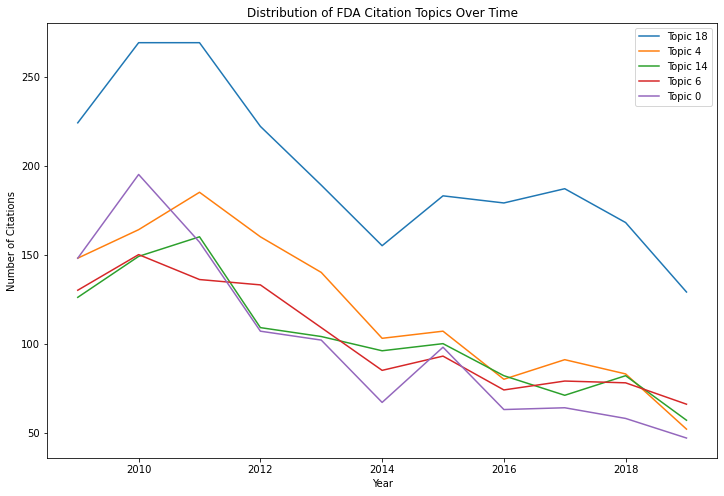

In [29]:
# plot the number of citation topics by month
import datetime

dc2 = dc2.rename(columns = {'Inspection End Date': 'date'})

yearmonth = []
year = []
for value in dc2['date']:
    d = value.strftime("%Y-%m-%d")
    x = re.search(r'[0-9]{4}-[0-9]{2}', d).group()
    y = int(x.replace('-', ''))
    z = int(re.search(r'[0-9]{4}', d).group())
    yearmonth.append(y)
    year.append(z)
dc2['yearmonth'] = yearmonth
dc2['year'] = year

dc_plot = dc2[(dc2['year'] > 2008) & (dc2['year'] < 2020)].groupby(
    ['year', 'topic_number']).size().reset_index(name = 'counts')
dcp = dc_plot.pivot(index = 'year', columns = 'topic_number', values = 'counts')

plt.figure(figsize = [12,8])

# plot all lines
#clmn = dcp.columns
#for i in clmn:
    #plt.plot(dcp[i], marker = '', label = i);

plt.plot(dcp['18'], label = 'Topic 18')
plt.plot(dcp['4'], label = 'Topic 4')
plt.plot(dcp['14'], label = 'Topic 14')
plt.plot(dcp['6'], label = 'Topic 6')
plt.plot(dcp['0'], label = 'Topic 0')

plt.legend(loc = "best")
plt.title("Distribution of FDA Citation Topics Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Citations");

## Predict Edge Pharma FDA Audit 2020 Form 483

In [30]:
edge_df = pd.read_excel("edge_pharma_2020.xlsx")

edge = edge_df.long_description.values.tolist()

# remove distracting single quotes
edge = [re.sub("\'", "", sent) for sent in edge]

pprint(edge[:1])

['There is a failure to thoroughly review any unexplained discrepancy and the '
 'failure of a batch or any of its components to meet any of its '
 'specifications whether or not the batch has already been distributed.']


In [31]:
edge_words = list(sent_to_words(edge))

edge_words[:1]

[['there',
  'is',
  'failure',
  'to',
  'thoroughly',
  'review',
  'any',
  'unexplained',
  'discrepancy',
  'and',
  'the',
  'failure',
  'of',
  'batch',
  'or',
  'any',
  'of',
  'its',
  'components',
  'to',
  'meet',
  'any',
  'of',
  'its',
  'specifications',
  'whether',
  'or',
  'not',
  'the',
  'batch',
  'has',
  'already',
  'been',
  'distributed']]

In [32]:
# Build the bigram and trigram models
bigram_e = gensim.models.Phrases(edge_words, min_count = 5, threshold = 100)
trigram_e = gensim.models.Phrases(edge_words, min_count = 5, threshold = 100)

# Faster way to get a sentence clubbed as a trigram/brigram
bigram_mod_e = gensim.models.phrases.Phraser(bigram_e)
trigram_mod_e = gensim.models.phrases.Phraser(trigram_e)

trigram_mod_e[bigram_mod_e[edge_words[0]]]

['there',
 'is',
 'failure',
 'to',
 'thoroughly',
 'review',
 'any',
 'unexplained',
 'discrepancy',
 'and',
 'the',
 'failure',
 'of',
 'batch',
 'or',
 'any',
 'of',
 'its',
 'components',
 'to',
 'meet',
 'any',
 'of',
 'its',
 'specifications',
 'whether',
 'or',
 'not',
 'the',
 'batch',
 'has',
 'already',
 'been',
 'distributed']

In [33]:
# remove stop words
edge_words_nostops = remove_stopwords(edge_words)

# form bigrams
edge_words_bigrams = make_bigrams(edge_words_nostops)

# do lemmatization keeping only noun, adj, vb, adv
edge_lemmatized = lemmatization(edge_words_bigrams)

In [34]:
# Create dictionary
id2word_e = corpora.Dictionary(edge_lemmatized)

# Ceate corpus
texts_e = edge_lemmatized

# Term Document Frequency
corpus_e = [id2word.doc2bow(text) for text in texts_e]

# View
print(corpus_e[:1])

# human readable version of corpus
print([[(id2word_e[id], freq) for id, freq in cp] for cp in corpus_e[:1]])

[[(42, 1), (64, 1), (65, 2), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 1), (72, 1), (107, 1)]]
[[('contamination', 1), ('checking', 1), ('electronic', 2), ('mechanical', 1), ('performance', 1), ('performed', 2), ('proper', 1), ('routine', 1), ('authorized', 1), ('change', 1), ('submitted', 1)]]


In [35]:
# assign each citation to the most probable topic
topics_e = []
for line in edge_words_bigrams:
    te = [line]
    corpus2_e = [id2word_e.doc2bow(w) for w in te]
    Te_dis = list(lda_model[corpus2_e])[0]
    topics_e.append(max(Te_dis))
    
topics_e[:5]

[(3, 0.9208331),
 (15, 0.33566615),
 (15, 0.42594308),
 (16, 0.34168962),
 (16, 0.14585435)]

In [36]:
s_topics_e = pd.Series(topics_e)
s_topics_e

ec = edge_df
ec['topic_number'] = [n for (n, p) in s_topics_e.values]
ec['topic_probability'] = [p for (n, p) in s_topics_e.values]

ec['topic_number'] = ec['topic_number'].astype(str)

ec1 = ec.merge(topic_df, how = 'left', left_on = 'topic_number', right_on = 'topic_number')
ec1

,Firm Name,City,State,Country/Area,Inspection End Date,Program Area,Observation,long_description,topic_number,topic_probability,primary_topic,secondary_topic
0,"Edge Pharma, LLC",Colchester,VT,United States,2020-03-30,Drugs,1,There is a failure to thoroughly review any un...,3,0.920833,Equipment Calibration,Indeterminate
1,"Edge Pharma, LLC",Colchester,VT,United States,2020-03-30,Drugs,2,Aseptic processing areas are deficient regardi...,15,0.335666,Returned / Rejected Products and Retention,Management Training and Facility Maintenance
2,"Edge Pharma, LLC",Colchester,VT,United States,2020-03-30,Drugs,3,Test procedures relative to appropriate labora...,15,0.425943,Returned / Rejected Products and Retention,Management Training and Facility Maintenance
3,"Edge Pharma, LLC",Colchester,VT,United States,2020-03-30,Drugs,4,The written stability testing program is not f...,16,0.341690,Lab Release Testing,Indeterminate
4,"Edge Pharma, LLC",Colchester,VT,United States,2020-03-30,Drugs,5,Aseptic processing areas are deficient regardi...,16,0.145854,Lab Release Testing,Indeterminate
5,"Edge Pharma, LLC",Colchester,VT,United States,2020-03-30,Drugs,6,Procedures designed to prevent microbiological...,18,0.338878,"Product Sampling, Storage, and Shipment",Indeterminate
6,"Edge Pharma, LLC",Colchester,VT,United States,2020-03-30,Drugs,7,Aseptic processing areas are deficient regardi...,15,0.150048,Returned / Rejected Products and Retention,Management Training and Facility Maintenance
7,"Edge Pharma, LLC",Colchester,VT,United States,2020-03-30,Drugs,8,"Buildings used in the manufacturing, processin...",15,0.101139,Returned / Rejected Products and Retention,Management Training and Facility Maintenance
8,"Edge Pharma, LLC",Colchester,VT,United States,2020-03-30,Drugs,9,"Routine calibration and checking of automatic,...",15,0.066410,Returned / Rejected Products and Retention,Management Training and Facility Maintenance
9,"Edge Pharma, LLC",Colchester,VT,United States,2020-03-30,Drugs,10,Appropriate controls are not exercised over co...,18,0.218308,"Product Sampling, Storage, and Shipment",Indeterminate


### References
Topic Modeling Structure Inspired By: 
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#14computemodelperplexityandcoherencescore